In [33]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds


from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.18.0


In [34]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)

In [35]:
print(train_data.shape)
print(train_labels.shape)
print(train_data[0])
print(train_labels[0])

(25000,)
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


In [36]:
# Dictionary that hashes words to their integer
word_to_integer = tf.keras.datasets.imdb.get_word_index()

# Print out the first ten keys in the dictionary
print(list(word_to_integer.keys())[0:10])

integer_to_word = dict([(value, key) for (key, value) in word_to_integer.items()])

# Demonstrate how to find the word from an integer
print(integer_to_word[1])
print(integer_to_word[2])

# We need to subtract 3 from the indices because 0 is "padding", 1 is "start of sequence", and 2 is "unknown"
decoded_review = ' '.join([integer_to_word.get(i - 3, 'UNK') for i in train_data[0]])
print(decoded_review)

['fawn', 'tsukino', 'nunnery', 'sonja', 'vani', 'woods', 'spiders', 'hanging', 'woody', 'trawling']
the
and
UNK this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert UNK is an amazing actor and now the same being director UNK father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for UNK and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also UNK to the two little boy's that played the UNK of norman and paul they were just brilliant children are often left out of the UNK list i think because the stars that play them all grown up are such a

In [37]:
def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

print(train_data.shape) # length is same as before
print(train_data[0]) # now, multi-hot encoded

# Vectorize the labels as well and reshape from (N, ) to (N, 1)
train_labels = np.reshape(np.asarray(train_labels, dtype=np.float32), (len(train_data), 1))
test_labels = np.reshape(np.asarray(test_labels, dtype=np.float32), (len(test_data), 1))

(25000, 10000)
[0. 1. 1. ... 0. 0. 0.]


In [45]:
# Create a model
model = tf.keras.Sequential()

 # input shape here is the length of our movie review vector
model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu, input_shape=(10000,)))
model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 8)              │        80,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,161 (313.13 KB)

 Trainable params: 80,161 (313.13 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
VAL_SIZE = 10000

val_data = train_data[:VAL_SIZE]
partial_train_data = train_data[VAL_SIZE:]


val_labels = train_labels[:VAL_SIZE]
partial_train_labels = train_labels[VAL_SIZE:]

In [47]:
BATCH_SIZE = 512
SHUFFLE_SIZE = 1000

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)

In [48]:
EPOCHS = 10

# Store list of metric values for plotting later
tr_loss_list = []
tr_accuracy_list = []
val_loss_list = []
val_accuracy_list = []

for epoch in range(EPOCHS):
    for reviews, labels in training_set:
        # Calculate training loss and accuracy
        tr_loss, tr_accuracy = model.train_on_batch(reviews, labels)
  
    # Calculate validation loss and accuracy
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)

    # Add to the lists
    tr_loss_list.append(tr_loss)
    tr_accuracy_list.append(tr_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
  
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
           'Validation Loss: %.2f\tValidation Accuracy: %.2f') % (epoch + 1,
                                                                  tr_loss, 
                                                                  tr_accuracy,
                                                                  val_loss,
                                                                  val_accuracy))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - binary_accuracy: 0.8322 - loss: 0.3827
Epoch #1	 Training Loss: 0.55	Training Accuracy: 0.71	Validation Loss: 0.38	Validation Accuracy: 0.83
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - binary_accuracy: 0.8685 - loss: 0.3441
Epoch #2	 Training Loss: 0.33	Training Accuracy: 0.86	Validation Loss: 0.35	Validation Accuracy: 0.86
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - binary_accuracy: 0.7749 - loss: 0.5765
Epoch #3	 Training Loss: 0.28	Training Accuracy: 0.89	Validation Loss: 0.57	Validation Accuracy: 0.78
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - binary_accuracy: 0.8803 - loss: 0.3169
Epoch #4	 Training Loss: 0.33	Training Accuracy: 0.87	Validation Loss: 0.31	Validation Accuracy: 0.88
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step - binary_accuracy: 0.8842 - loss: 0.3595
Epoch #5	 Training Loss: 0.21	Training Accuracy: 0.92	Validation Loss: 0.36	Validation Accuracy: 0.88
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - binary_accuracy: 0.8672 -

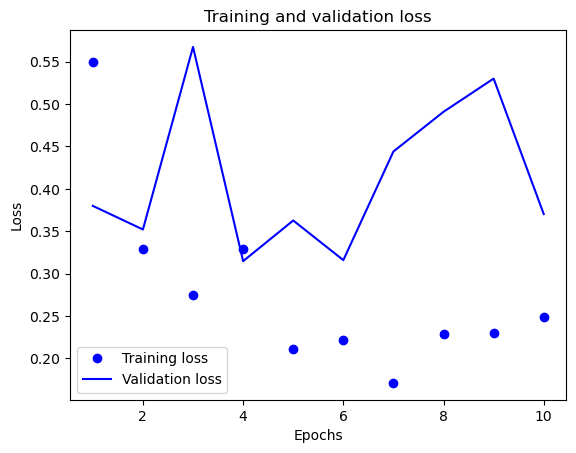

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# "bo" specifies "blue dot"
plt.plot(epochs, tr_loss_list, 'bo', label='Training loss')
# b specifies a "solid blue line"
plt.plot(epochs, val_loss_list, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

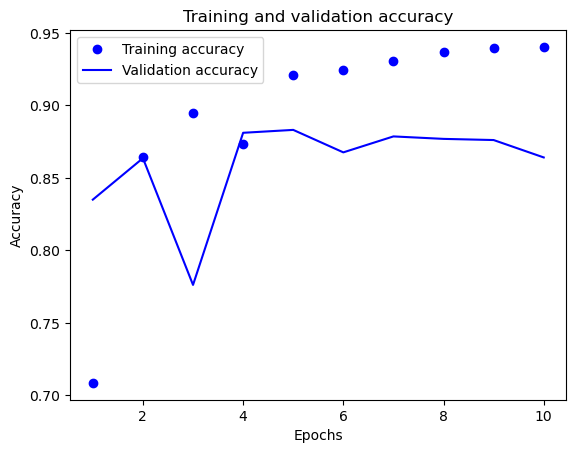

In [51]:
plt.clf()   # Clear plot

plt.plot(epochs, tr_accuracy_list, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy_list, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [52]:
loss, accuracy = model.evaluate(test_data, test_labels)
print('Test accuracy: %.2f' % (accuracy))

782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - binary_accuracy: 0.8514 - loss: 0.3928
Test accuracy: 0.85
